Replication of  this Kaggle notebook:
https://www.kaggle.com/code/tientd95/advanced-pyspark-for-exploratory-data-analysis/

In [59]:
##Importing python modules.

import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib

'''mpl_toolkits.mplot3d provides some basic 3D plotting (scatter, surf, line, mesh) tools. Not the fastest or most feature complete 3D library out there, but it ships with Matplotlib and thus may be a lighter weight solution for some use cases. Check out the mplot3d tutorial for more information.'''
from mpl_toolkits.mplot3d import Axes3D

import math

"An enhanced, interactive shell for Python."
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats

In [60]:
#Import pyspark relates modules.

# to convert data into RDDs
import pyspark
from pyspark.rdd import RDD

'''A row in DataFrame. The fields in it can be accessed:

like attributes (row.key)

like dictionary values (row[key])

key in row will search through row keys.

Row can be used to create a row object by using named arguments. It is not allowed to omit a named argument to represent that the value is None or missing. This should be explicitly set to None in this case.'''

from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
#from pyspark.sql import SQLContext

#pyspark.sql.functions List of built-in functions available for DataFrame.
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct, sum

from pyspark.sql.types import *

## Setting up spark session

-> spark.executor.heartbeatInterval : Interval between each executor's heartbeats to the driver. Heartbeats let the driver know that the executor is still alive and update it with metrics for in-progress tasks. spark.executor.heartbeatInterval should be significantly less than spark.network.timeout

-> spark.network.timeout: Default timeout for all network interactions. This config will be used in place of spark.storage.blockManagerHeartbeatTimeoutMs, spark.shuffle.io.connectionTimeout, spark.rpc.askTimeout or spark.rpc.lookupTimeout if they are not configured.

-> spark.core.connection.ack.wait.timeout: How long for the connection to wait for ack to occur before timing out and giving up. To avoid unwilling timeout caused by long pause like GC, you can set larger value.

-> spark.executor.memory & spark.driver.memory: Memory allocation to executors and drivers.

In [61]:
MAX_MEMORY = '10G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
        

In [62]:

spark = SparkSession.builder.appName("super_EDA1").getOrCreate()


In [63]:
## Reading data.

# mode="DROPMALFORMED"
df= spark.read.json("E:\\New journey\\Datasets\\endomodo\\endomondoHR.json", mode="DROPMALFORMED")

# Overview of Dataset

In [64]:
print("Data overview/Schema")
df.printSchema()

Data overview/Schema
root
 |-- altitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- gender: string (nullable = true)
 |-- heart_rate: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- id: long (nullable = true)
 |-- latitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- longitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- speed: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- sport: string (nullable = true)
 |-- timestamp: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- url: string (nullable = true)
 |-- userId: long (nullable = true)



In [65]:
df.limit(1).toPandas()

,altitude,gender,heart_rate,id,latitude,longitude,speed,sport,timestamp,url,userId
0,"[41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....",male,"[100, 111, 120, 119, 120, 116, 125, 128, 131, ...",396826535,"[60.173348765820265, 60.173239801079035, 60.17...","[24.64977040886879, 24.65014273300767, 24.6509...","[6.8652, 16.4736, 19.1988, 20.4804, 31.3956, 3...",bike,"[1408898746, 1408898754, 1408898765, 140889877...",https://www.endomondo.com/users/10921915/worko...,10921915


In [66]:
print("Columns overview")
pd.DataFrame(df.dtypes, columns=["Columns","Data type"])

Columns overview


,Columns,Data type
0,altitude,array<double>
1,gender,string
2,heart_rate,array<bigint>
3,id,bigint
4,latitude,array<double>
5,longitude,array<double>
6,speed,array<double>
7,sport,string
8,timestamp,array<bigint>
9,url,string


In [67]:
print('Data frame describe (string and numeric columns only):')
display(df.describe().toPandas())

print(f'There are total {df.count()} row, Lets print first 2 data rows:')
display(df.limit(2).toPandas())

Data frame describe (string and numeric columns only):


,summary,gender,id,sport,url,userId
0,count,253020,253020,253020,253020,253020
1,mean,None,3.566244412926132E8,None,None,4619648.939783417
2,stddev,None,1.574845634895318E8,None,None,3932877.7296880507
3,min,female,99296,aerobics,https://www.endomondo.com/users/10014612/worko...,69
4,max,unknown,674008008,yoga,https://www.endomondo.com/users/9991401/workou...,15481421


There are total 253020 row, Lets print first 2 data rows:


,altitude,gender,heart_rate,id,latitude,longitude,speed,sport,timestamp,url,userId
0,"[41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....",male,"[100, 111, 120, 119, 120, 116, 125, 128, 131, ...",396826535,"[60.173348765820265, 60.173239801079035, 60.17...","[24.64977040886879, 24.65014273300767, 24.6509...","[6.8652, 16.4736, 19.1988, 20.4804, 31.3956, 3...",bike,"[1408898746, 1408898754, 1408898765, 140889877...",https://www.endomondo.com/users/10921915/worko...,10921915
1,"[38.4, 39.0, 39.0, 38.2, 36.8, 36.8, 36.8, 35....",male,"[100, 105, 111, 110, 108, 115, 126, 130, 132, ...",392337038,"[60.173247596248984, 60.17320962622762, 60.172...","[24.649855233728886, 24.65015547350049, 24.650...","[9.0792, 13.284, 15.9336, 10.9476, 16.1676, 30...",bike,"[1408221682, 1408221687, 1408221699, 140822170...",https://www.endomondo.com/users/10921915/worko...,10921915


# Detect missing values and abnormal zeroes.

After having a first sight of the columns, the first thing we should check is if the data set having any missing value.

-> For string columns, we check for None and null

-> For numeric columns, we check for zeroes and NaN

-> For array type columns, we check if the array contain zeroes or NaN

In [68]:
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Columns overview


,Column Name,Data type
0,altitude,array<double>
1,gender,string
2,heart_rate,array<bigint>
3,id,bigint
4,latitude,array<double>
5,longitude,array<double>
6,speed,array<double>
7,sport,string
8,timestamp,array<bigint>
9,url,string


In [69]:
string_columns =["gender", "sport", "url"]
numeric_columns= ["id","userId"]
array_columns=["altitude","heart_rate","latitude","longitude","timestamp"]

missing_values={}

In [70]:
for index, column in enumerate(df.columns):
    
    if column in string_columns:        
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()        
        
    if column in numeric_columns:  # check zeroes, None, NaN
        missing_count = df.where(col(column).isin([0,None,np.nan])).count()        
        
    if column in array_columns:  # check zeros and NaN
        missing_count = df.filter(array_contains(df[column], 0) | array_contains(df[column], np.nan)).count()
    
    missing_values.update({column:missing_count})
        
missing_df = pd.DataFrame.from_dict([missing_values])

In [71]:
print("Missing/abnormal values by column")
missing_df

Missing/abnormal values by column


,altitude,gender,heart_rate,id,latitude,longitude,speed,sport,timestamp,url,userId
0,40848,0,1280,0,113,113,113,0,0,0,0


In [72]:
##New column for number of timestamps per column.
df=df.withColumn("PerWorkoutRecordCount",size(col("timestamp")))

# This part is writen as a function to be used again later.
def user_activity_workout_summarize(df):
    user_count = format(df.select('userId').distinct().count(), ',d')
    workout_count = format(df.select('id').distinct().count(),',d')
    activity_count = str(df.select("sport").distinct().count())    
    #Total number of records/instances of workouts that are recorded.
    sum_temp = df.agg(sum('PerWorkoutRecordCount')).toPandas()
    total_records_count = format(sum_temp['sum(PerWorkoutRecordCount)'][0],",d")        
    columns=['Users count', 'Activity types count','Workouts count', 'Total records count']
    data = [[user_count], [activity_count], [workout_count], [total_records_count]]    
    sum_dict = {column:data[index] for index, column in enumerate(columns)}
    # Dataframe containing the total number of users, number of workouts, total number of activities.
    sum_df =  pd.DataFrame.from_dict(sum_dict)
    
    #No of users of each gender
    gender_user_count = df.select("gender","userId").distinct().groupBy("gender").count().toPandas()        
    #No off records/actvities from each gender
    gender_user_activity_count= df.groupBy("gender").count().toPandas()    
    #joining the 2 tables.
    gender_user_activity_count = gender_user_count.join(gender_user_activity_count.set_index("gender"), on="gender", how="inner", lsuffix="_gu")
    #renaming the columns
    gender_user_activity_count.columns = ['Gender', '# of users', 'Activities (workouts) count']
    
    return sum_df, gender_user_activity_count
    

In [73]:
#Using the function.
sum_dfs = user_activity_workout_summarize(df)

print('\nOverall data set summary on users, workouts and number of records (pre-filtering):')
sum_dfs[0]


Overall data set summary on users, workouts and number of records (pre-filtering):


,Users count,Activity types count,Workouts count,Total records count
0,"1,104",49,"253,020","111,541,956"


### From previous data, we can see that the number of records are more than 111M.

## This is a huge dataset.

In [74]:
print('Number of workouts that have less than 50 records and statistic summary:')

## decribe() in  pandas works different than in pyspark. 
removed_df=df.select("PerWorkoutRecordCount").where(df["PerWorkoutRecordCount"]<50).toPandas().describe().astype(int)

removed_df.rename(columns = {'PerWorkoutRecordCount': 'PerWorkoutRecordCount <50'}, inplace=True)

#transpose
removed_df.T

Number of workouts that have less than 50 records and statistic summary:


,count,mean,std,min,25%,50%,75%,max
PerWorkoutRecordCount <50,5541,23,14,1,11,22,36,49


# Pyspark lazy evaluation.

Here we will begin to be familiar with some of Advanced Spark feature: Lazy evaluation.

Lazy evaluation enhances the power of Apache Spark by reducing the execution time of the RDD operations. It maintains the lineage graph to remember the operations on RDD. we can simply remember that all processing in Pyspark is abstraction, When we want to return the results, actually we tell Spark what is the eventual answer you're interested and it figures out best way to get there. As a result, it optimizes the performance and achieves fault tolerance.

In order to see the result, we have to call Spark.collect().

Normolly, we can show the results with the syntax: df.take(k) or df.limit(k) to get the results with k row.

When K become large number, These 2 way above takes a long time to complete the process. Because this syntax above did not utilize the power of Pyspark processing (Lazy evaluation). In order to quickly processing , We should use df.collect()[:k] to return the k row as we want.

You can read more about Pyspark lazy evaluation in : https://data-flair.training/blogs/apache-spark-lazy-evaluation/

In [75]:
df.columns

['altitude',
 'gender',
 'heart_rate',
 'id',
 'latitude',
 'longitude',
 'speed',
 'sport',
 'timestamp',
 'url',
 'userId',
 'PerWorkoutRecordCount']

In [76]:
# No of users in every sport.

ranked_sport_users_df= df.select("sport","id").distinct().groupBy("sport").count().orderBy("count", ascending=False)

In [77]:
# top 5 sports by users
highest_sport_users_df = ranked_sport_users_df.limit(5).toPandas()

#renaming the column
highest_sport_users_df.rename(columns={'count':'Users count'}, inplace=True)

# Caculate the total users, we will use this result to compute percentage later
total_sports_users=ranked_sport_users_df.groupBy().sum().collect()[0][0]


In [78]:
ranked_sport_users_df.collect()[:5]

[Row(sport='run', count=117902),
 Row(sport='bike', count=98001),
 Row(sport='mountain bike', count=13510),
 Row(sport='bike (transport)', count=10445),
 Row(sport='walk', count=3831)]

# EDA

First we'll do some charts that indicate the top 5 workout types.


In [79]:
# We'll get the percentage of users in the top 5 sports.

highest_sport_users_df_renamed = highest_sport_users_df
highest_sport_users_df_renamed["percentage"] = (highest_sport_users_df["Users count"] / total_sports_users)*100

# We assign the rest of the users to another specific group that we call 'others'.

Others = {    
    'sport':'others',
    'Users count': total_sports_users - highest_sport_users_df_renamed["Users count"].sum(),
    'percentage': highest_sport_users_df_renamed["percentage"].sum()        
}

highest_sport_users_df_renamed=highest_sport_users_df_renamed.append(Others, ignore_index=True)

print('Top 5 sports that have the most users participated:')
highest_sport_users_df_renamed


Top 5 sports that have the most users participated:


,sport,Users count,percentage
0,run,117902,46.597897
1,bike,98001,38.732511
2,mountain bike,13510,5.339499
3,bike (transport),10445,4.128132
4,walk,3831,1.514110
5,others,9331,96.312149


### Creating graphs for the top 5 sports

<ipython-input-80-7179e3bbb97e>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  xsticks_label= axs[0].set_xticklabels(highest_sport_users_df_renamed['sport'] ,rotation = 'vertical', fontsize='small')


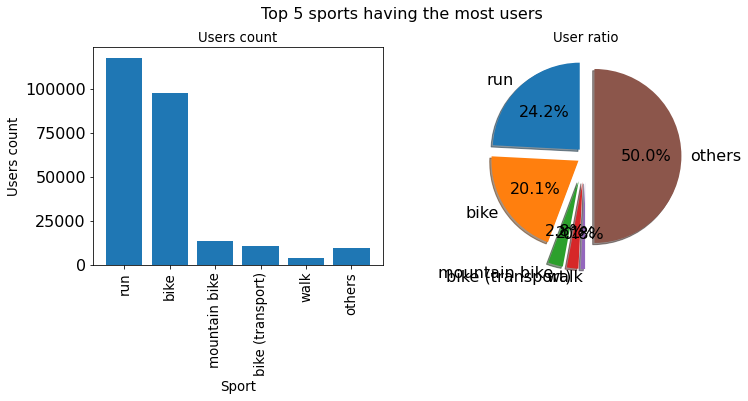

In [80]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))

plot0= axs[0].bar(x=highest_sport_users_df_renamed["sport"], height =highest_sport_users_df_renamed["Users count"])
title0= axs[0].set_title('Users count', fontsize = 'small')
x_label= axs[0].set_xlabel('Sport', fontsize = 'small')
y_label= axs[0].set_ylabel('Users count', fontsize = 'small')
xsticks_label= axs[0].set_xticklabels(highest_sport_users_df_renamed['sport'] ,rotation = 'vertical', fontsize='small')

explode = (0.1, 0.1, 0.3, 0.3, 0.3, 0.1)
title1= axs[1].set_title("User ratio", fontsize="small")
plot1= axs[1].pie(x=highest_sport_users_df_renamed["percentage"], labels=highest_sport_users_df_renamed['sport'], autopct= "%1.1f%%", shadow= True, radius=1, startangle=90, explode=explode)

text = fig.text(0.5, 1.02, 'Top 5 sports having the most users', ha='center', va='top', transform=fig.transFigure)

The data shows that running, walking and biking-related activities are the most spent by users, which is quite reasonable due to those exercises' convenience without much investment :3

In [81]:
## overview of activities by gender:

activities_by_gender =df.groupBy("sport","gender").count().orderBy("sport", "gender").toPandas()

In [82]:
#top 5
activities_by_gender[:5] 

,sport,gender,count
0,aerobics,female,3
1,aerobics,male,43
2,badminton,male,17
3,basketball,male,14
4,beach volleyball,male,2


# UNSTACK dataframe

We want reshape the table above to flatten the gender column so that we can visualize on it. I draw a simple draft as follow:

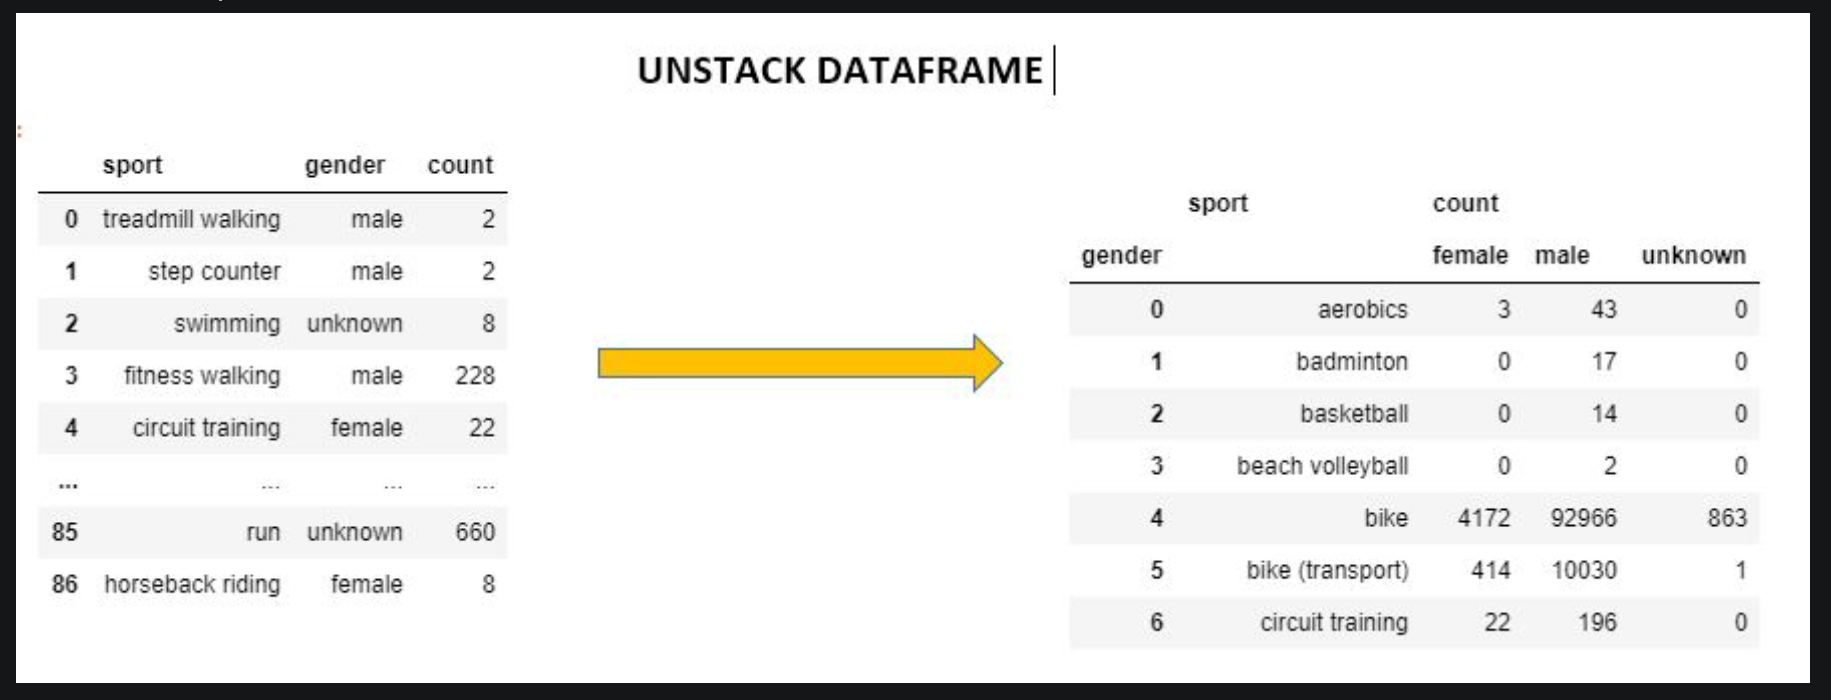

To reshape the table like this in Pyspark, we use

df.unstack()

There are total: 49 activities and here is the chart for activities based on gender:


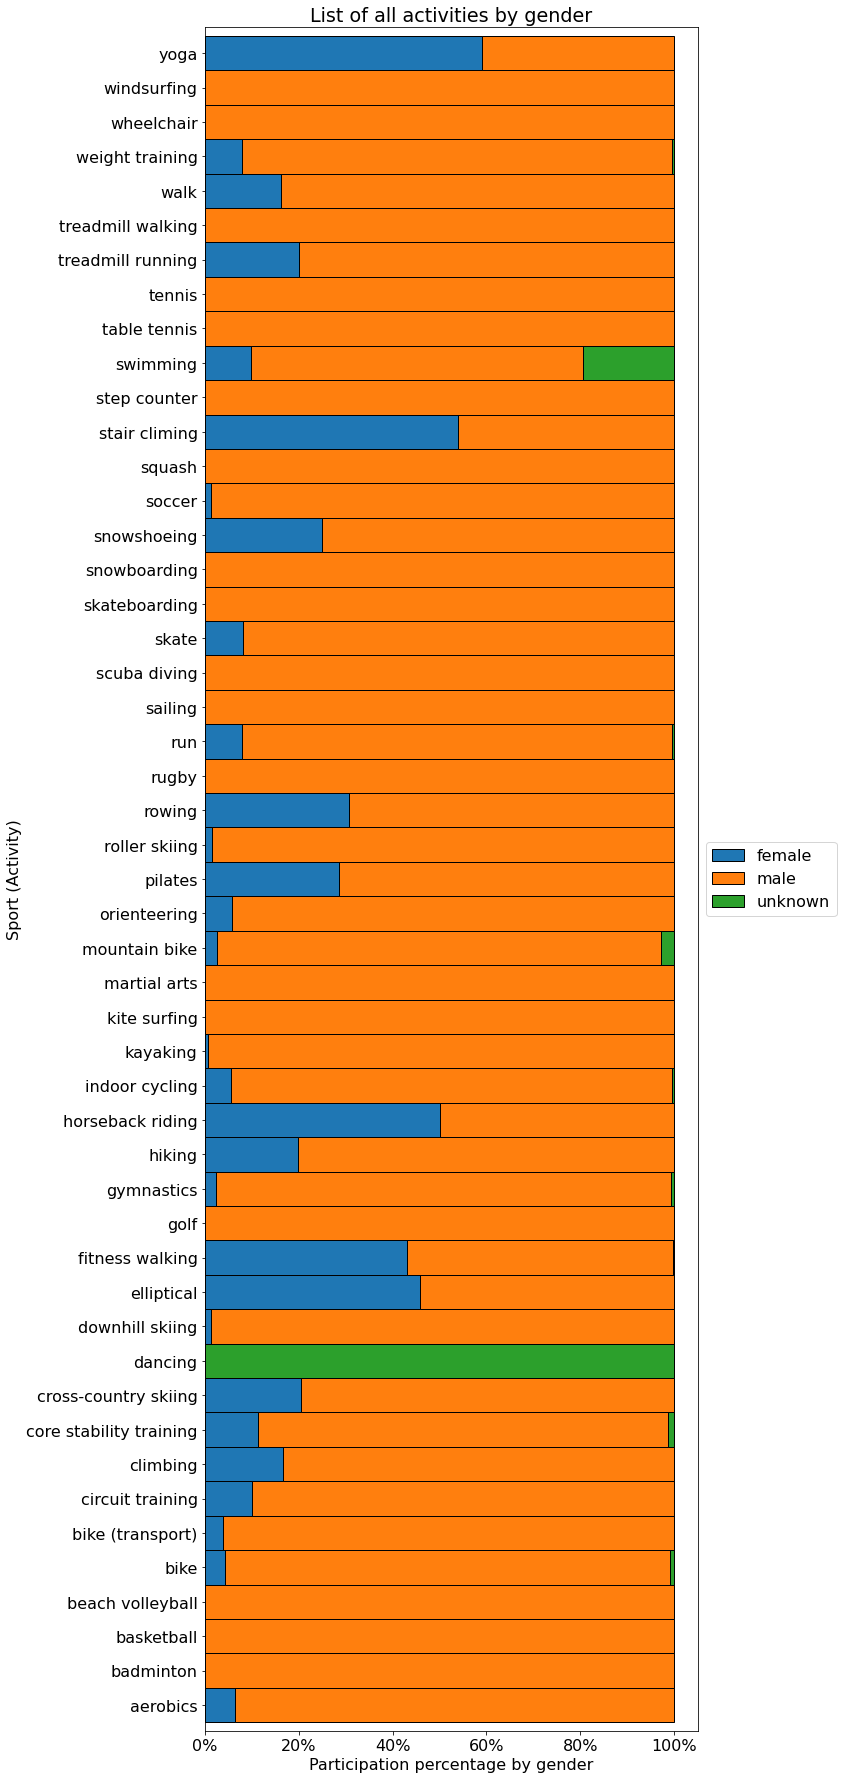

In [83]:
total_activities=ranked_sport_users_df.count()
print(f'There are total: {total_activities} activities and here is the chart for activities based on gender:')

# Add the infor of activities based on gender
activities_by_gender

# Visualize
fig = plt.figure(figsize=(12, 25))
grid_size = (1,1);
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)

activities_by_gender.groupby(['sport', 'gender']).agg(np.mean).groupby(level=0).apply(lambda x: (x*100)/x.sum()).unstack().plot(kind="barh", stacked=True, width =1, edgecolor='black', ax=ax, title='List of all activities by gender')

ylabel = plt.ylabel('Sport (Activity)');
xlabel = plt.xlabel('Participation percentage by gender');
legend = plt.legend(
    sorted(activities_by_gender['gender'].unique()), loc='center left', bbox_to_anchor=(1.0, 0.5)
)
param_update = plt.rcParams.update({'font.size': 16});
ax = plt.gca()
formatter = ax.xaxis.set_major_formatter(mtick.PercentFormatter());
a = fig.tight_layout()
plt.show()

Let's look at the top pareto of 5 sports that have the most participation.

In [84]:
activities_by_gender_df= activities_by_gender.pivot_table(index= "sport", columns="gender",values="count", fill_value=0).reset_index().rename_axis(None, axis=1)

## Adding 
activities_by_gender_df['total']=activities_by_gender_df['female'] + activities_by_gender_df['male'] + activities_by_gender_df['unknown']

activities_by_gender_df['percentage']= (activities_by_gender_df['total']/ activities_by_gender_df['total'].sum())*100


In [85]:
top_activities_by_gender_df = activities_by_gender_df.sort_values(by="percentage", ascending= False).head(5)
others = {'sport' : 'others'}

for column in ['female', 'male', 'unknown', 'total', 'percentage']:
    value= (activities_by_gender_df[column]).sum() -(top_activities_by_gender_df[column]).sum()
    others.update({column:value})
top_activities_by_gender_df= top_activities_by_gender_df.append(others, ignore_index=True)
top_activities_by_gender_df = top_activities_by_gender_df.sort_values(by= "percentage", ascending=False)

<ipython-input-86-0504ce27c84b>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  xsticks_label = axs[0].set_xticklabels(top_activities_by_gender_df['sport'], rotation='vertical', fontsize='small')


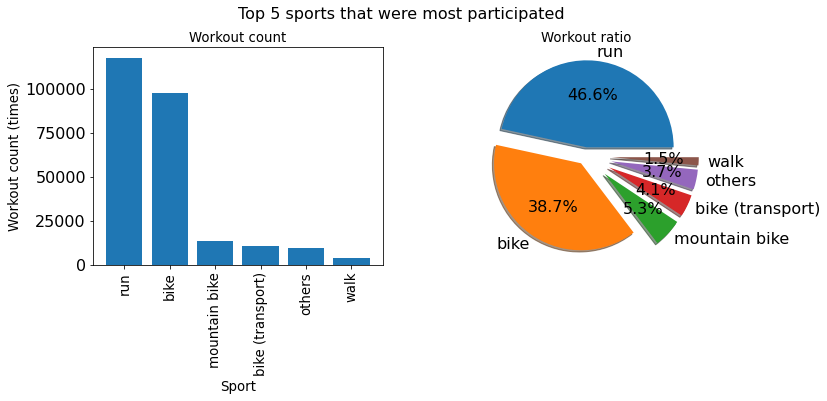

In [86]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))
plot0= axs[0].bar(x=top_activities_by_gender_df['sport'], height=top_activities_by_gender_df['total'])

title0 = axs[0].set_title("Workout count", fontsize="small")
xlabel0 = axs[0].set_xlabel('Sport', fontsize='small')
ylabel0 = axs[0].set_ylabel('Workout count (times)', fontsize='small')

xsticks_label = axs[0].set_xticklabels(top_activities_by_gender_df['sport'], rotation='vertical', fontsize='small')

explode = (0.1, 0.1, 0.3, 0.3, 0.3, 0.3)
title1 = axs[1].set_title('Workout ratio', fontsize = 'small')

plot1 = axs[1].pie(
    x=top_activities_by_gender_df['percentage']
    , labels=top_activities_by_gender_df['sport']
    , autopct='%1.1f%%', shadow=True, explode=explode, radius=1
)

text = fig.text(0.5, 1.02, 'Top 5 sports that were most participated', ha='center', va='top', transform=fig.transFigure)

Once again, similar to the user participation, running, walking and biking are also the dominant contribution interm of number of workout counts. However, the only different is that pure running and biking activities count is much bigger than those of the remaining sports, and the total count of those 2 already take up to more than 85% of total activities.

# Lets play with some question such as how many people participated in more than 1 sport.

In [87]:
min_number_of_sports=1

sport_df = df.select(df.userId, df.gender, df.sport).distinct().groupBy(df.userId, df.gender).count() 

user_more_sports_df = sport_df.filter(sport_df["count"]>min_number_of_sports).orderBy("count", ascending=False).toPandas()

user_more_sports_df.rename(columns={'count':'Sports count'}, inplace=True)


In [88]:
user_more_sports_df.describe().astype(int).T

,count,mean,std,min,25%,50%,75%,max
userId,822,4860464,3953412,69,1609606,3730685,7554937,15481421
Sports count,822,3,2,2,2,3,5,16


Based on the summary, there are 822 persons participated more than 1 sport. Among them in average a person take part in about 3 sports and there is some person playing up to 16 sports!
Now we look at the statistic by gender in box plot:

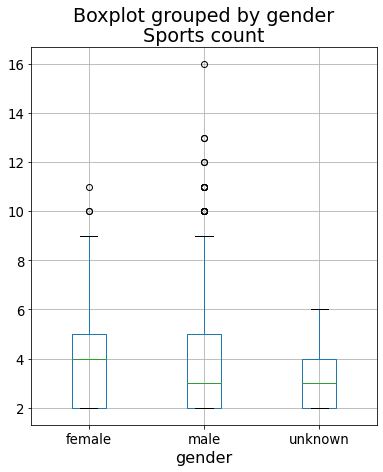

In [89]:
plot = user_more_sports_df.boxplot(column='Sports count', by='gender', fontsize='small', figsize=(6,7))


Plot of workouts distribution by activity type:


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\hist.py:396: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


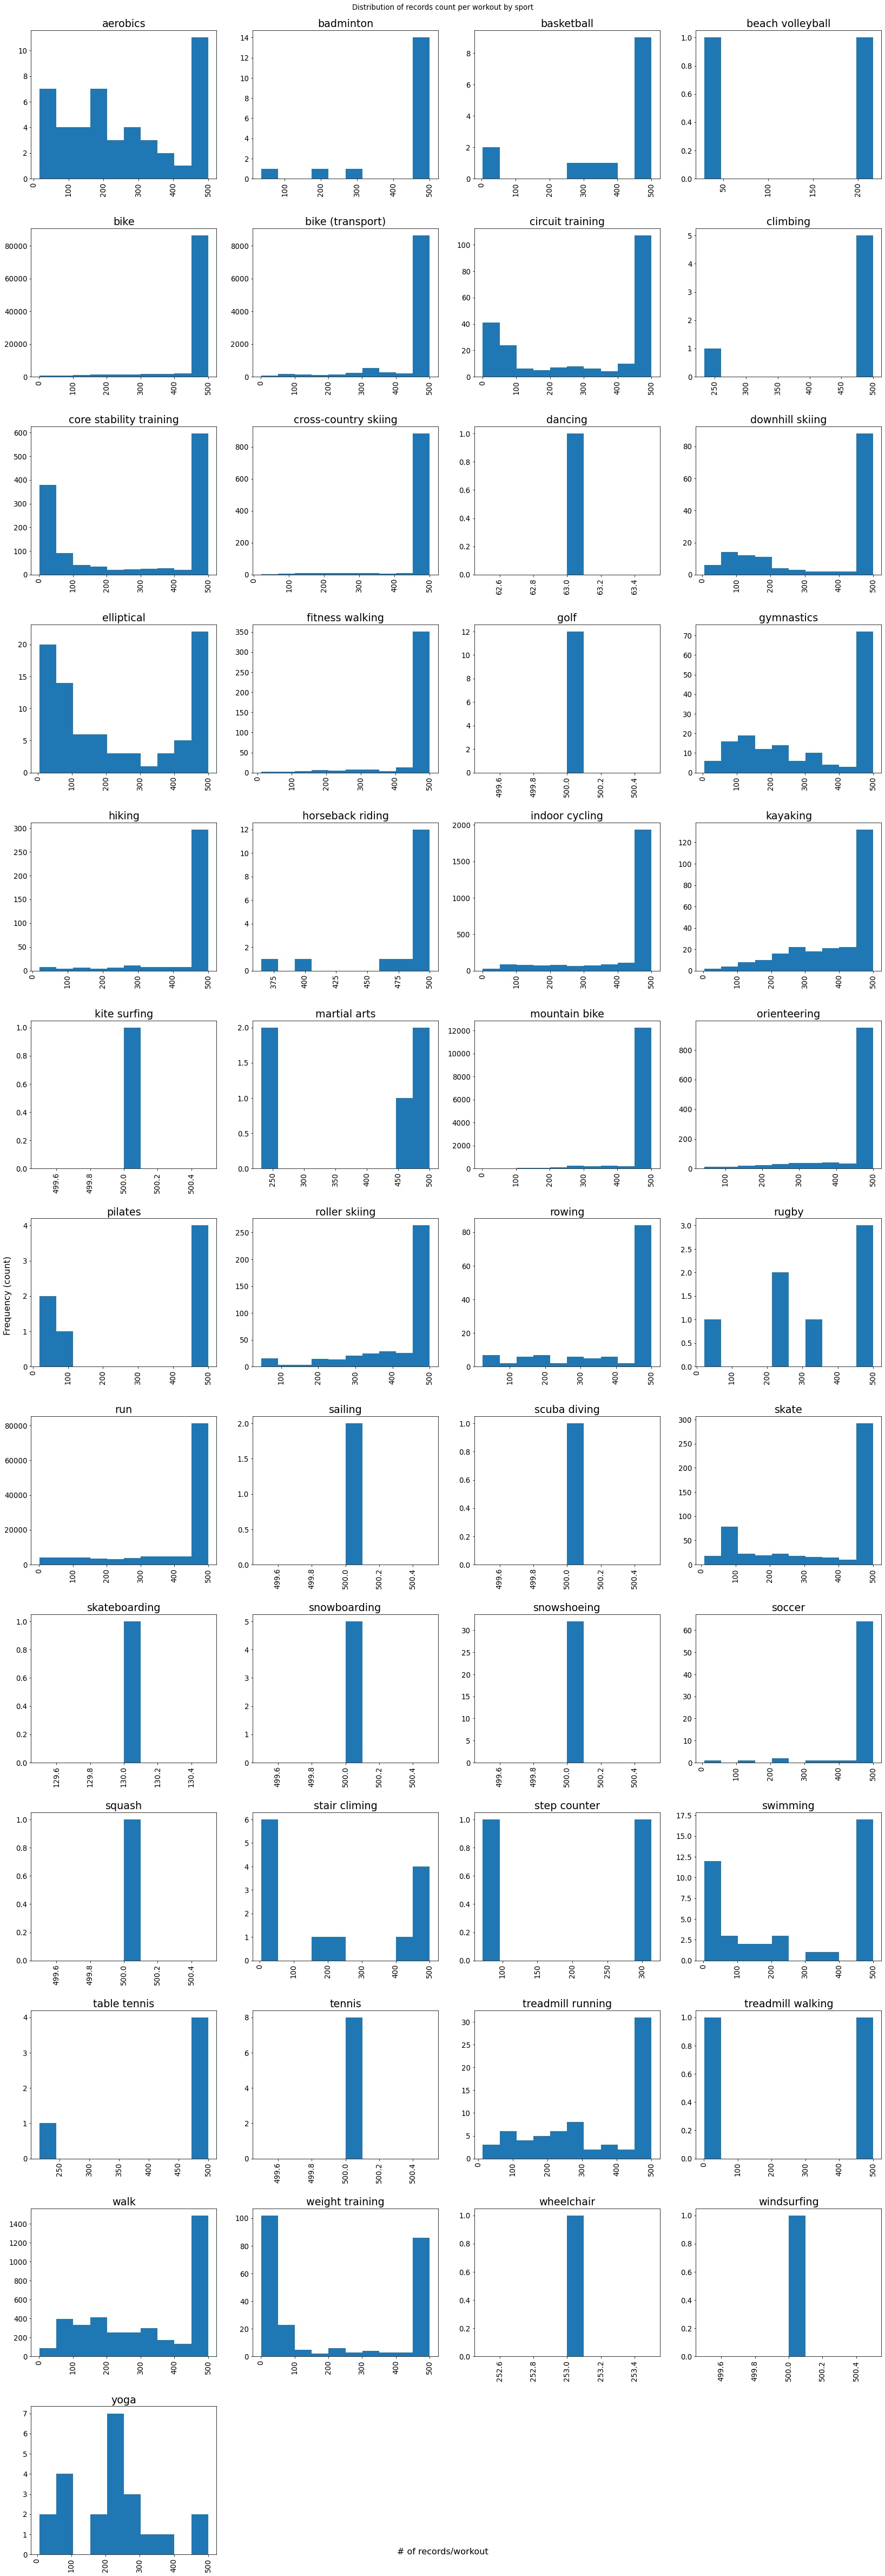

In [90]:
print('\nPlot of workouts distribution by activity type:')
plot_size_x, plot_size_y = 5, 5
figsize_x, figsize_y = plot_size_x * 4 + 3, plot_size_y * 13 + 1
figsize=(figsize_x, figsize_y)
fig = plt.figure(figsize=figsize) #
grid_size = (13,4)
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)
#fig, ax = plt.subplots()
PerWorkoutRecordCount_dist = df.select('PerWorkoutRecordCount', 'sport').toPandas().hist(
    column='PerWorkoutRecordCount', bins=10, sharex = False, grid=True
    , xlabelsize='small', ylabelsize='small', by='sport', ax = ax
    , layout = grid_size, figsize=figsize
    )
a = fig.tight_layout()
title = fig.text(0.5, 1, 'Distribution of records count per workout by sport', ha='center' 
         , fontsize='small', transform=fig.transFigure);
xlabel = fig.text(
    0.5, 0.01, '# of records/workout', va='bottom', ha='center', transform=fig.transFigure
)
ylabel = fig.text(0.01, 0.5, 'Frequency (count)', va='center', rotation='vertical');

# Pyspark UDF Registering 

To be in short, Registering UDF to Pyspark is the process of turning Python Functions into PySpark Functions (UDF)

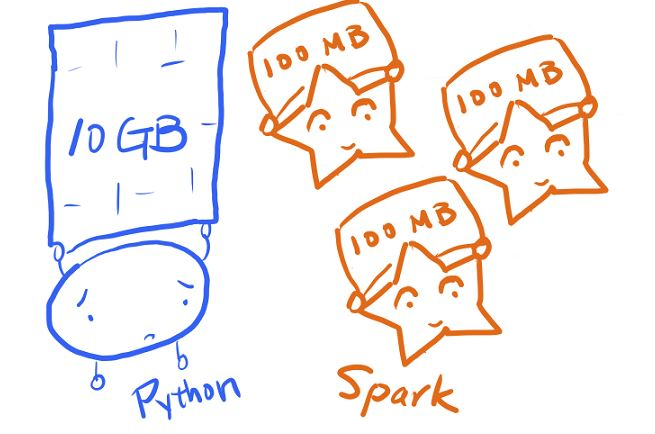Registering%20UDF%20to%20Pypark.JPG

When we run the code on Spark clusters, this technique will speed up the process and save valuable executed time.

To learn more about Pyspark UDF, you can visit https://changhsinlee.com/pyspark-udf/

Okie now we will start to apply registering python function to UDF in the 'timestamp' column

This column is very important if we use this dataset to predict something, like predict heart rate to soonly detect some bad signal on user's heart. Because this is a type of time series analysis, so we will look at the timestamp column carefully.


Creating some new features from timestamp
As seen before timestamp column contains records of timestamp series of a single workout (a data row) and is stored in UNIX timestamp format. To have more insights on this column, we will create 4 more new columns from it:

-> date_time: Convert UNIX timestamp into python's datetime format
-> duration: Total time of a single workout, in minute
In order to get the workout duration, we get the difference between max and min of the datetime list of each workout.
-> workout_start_time: Determine when, which hour of the day a workout start
For workout_start_time, it's the hour part of the first datetime record of a workout.
-> interval: List of time lapses between each single timestamp record in a single workout, in second
And for interval, we will calculate it by taking the difference between 2 consecutive timestamp records within a workout.
In order to attach these 4 features to SparkdDataFrame, we register them with PYSPARK UDF

In [91]:
# LOOK AGAIN THE TIMESTAMP COLUMN
df.limit(3).toPandas()

,altitude,gender,heart_rate,id,latitude,longitude,speed,sport,timestamp,url,userId,PerWorkoutRecordCount
0,"[41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....",male,"[100, 111, 120, 119, 120, 116, 125, 128, 131, ...",396826535,"[60.173348765820265, 60.173239801079035, 60.17...","[24.64977040886879, 24.65014273300767, 24.6509...","[6.8652, 16.4736, 19.1988, 20.4804, 31.3956, 3...",bike,"[1408898746, 1408898754, 1408898765, 140889877...",https://www.endomondo.com/users/10921915/worko...,10921915,500
1,"[38.4, 39.0, 39.0, 38.2, 36.8, 36.8, 36.8, 35....",male,"[100, 105, 111, 110, 108, 115, 126, 130, 132, ...",392337038,"[60.173247596248984, 60.17320962622762, 60.172...","[24.649855233728886, 24.65015547350049, 24.650...","[9.0792, 13.284, 15.9336, 10.9476, 16.1676, 30...",bike,"[1408221682, 1408221687, 1408221699, 140822170...",https://www.endomondo.com/users/10921915/worko...,10921915,500
2,"[76.4, 73.2, 72.4, 73.0, 73.0, 70.8, 69.2, 69....",male,"[99, 105, 113, 110, 109, 110, 108, 121, 116, 1...",389643739,"[60.17326201312244, 60.173205351457, 60.172969...","[24.64995657093823, 24.650197718292475, 24.651...","[4.0464, 13.8204, 16.9776, 19.9404, 28.7856, 3...",bike,"[1407858459, 1407858466, 1407858478, 140785849...",https://www.endomondo.com/users/10921915/worko...,10921915,500


In [99]:
# Convert a timestamp column into Datetime.Datetime, to be used for .withColumn function later
def to_time(timestamp_list):
    # convert to datetime and minus 7 hours due to the difference in Endomondo time window with utc time as the dataset description
    return [datetime.fromtimestamp(t) - timedelta(hours=7) for t in timestamp_list]

udf_to_time = udf(to_time, ArrayType(elementType=TimestampType()))

# Support function to get the duration (in minutes) of a list of datetime values, to be used for withColumn function later.
def get_duration(datetime_list):
    time_dif = max(datetime_list) - min(datetime_list)
    return time_dif.seconds/60

# Register the support function 'get_duration' as a user defined function into pyspark framework
udf_get_duration = udf(get_duration, FloatType())

# Support function to get the workout start time of the datetime list, to be used for withColumn function later
def get_start_time(datetime_list):
    return min(datetime_list)

# Register the support function 'get_start_time' as a user defined function into pyspark framework
udf_get_start_time = udf(get_start_time, TimestampType())


# Support function to get list of intervals within a workout
def get_interval(datetime_list):
    if len(datetime_list) == 1:
        return [0]
    else:
        interval_list = []
        for i in range(0, len(datetime_list)-1):
            interval = (datetime_list[i+1] - datetime_list[i]).seconds
            interval_list.append(interval)
        return interval_list

# Register the support function 'get_interval' as a user defined function into pyspark framework    
udf_get_interval = udf(get_interval, ArrayType(elementType=IntegerType()))

# Create new 'date_time' column to convert from timestamp into python's datetime format for later usage
df = df.withColumn('date_time', udf_to_time('timestamp'))


# Create 'workout_start_time' column to get the start time of each workout/row:
df = df.withColumn('workout_start_time', hour(udf_get_start_time('date_time')))

# Create duration column from the date_time column just created, using the udf function udf_get_duration defined above
df = df.withColumn('duration', udf_get_duration('date_time'))

# Create interval column from the date_time column, using the udf function udf_get_interval defined above
df = df.withColumn('interval', udf_get_interval('date_time'))

df.select('timestamp','date_time', 'workout_start_time', 'duration', 'interval').limit(5).toPandas()



Py4JJavaError: An error occurred while calling o1210.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 172.0 failed 1 times, most recent failure: Lost task 0.0 in stage 172.0 (TID 11354) (LAPTOP-QNSFU41R executor driver): java.io.IOException: Cannot run program "python3": CreateProcess error=2, The system cannot find the file specified
	at java.lang.ProcessBuilder.start(ProcessBuilder.java:1048)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:165)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:107)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:119)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:145)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:81)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:130)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:863)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:863)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.io.IOException: CreateProcess error=2, The system cannot find the file specified
	at java.lang.ProcessImpl.create(Native Method)
	at java.lang.ProcessImpl.<init>(ProcessImpl.java:453)
	at java.lang.ProcessImpl.start(ProcessImpl.java:140)
	at java.lang.ProcessBuilder.start(ProcessBuilder.java:1029)
	... 25 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2258)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2207)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2206)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1079)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2445)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2387)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2376)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2196)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2217)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2236)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:472)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:425)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:47)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:3519)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3687)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3685)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3516)
	at sun.reflect.GeneratedMethodAccessor180.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.io.IOException: Cannot run program "python3": CreateProcess error=2, The system cannot find the file specified
	at java.lang.ProcessBuilder.start(ProcessBuilder.java:1048)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:165)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:107)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:119)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:145)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:81)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:130)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:863)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:863)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.io.IOException: CreateProcess error=2, The system cannot find the file specified
	at java.lang.ProcessImpl.create(Native Method)
	at java.lang.ProcessImpl.<init>(ProcessImpl.java:453)
	at java.lang.ProcessImpl.start(ProcessImpl.java:140)
	at java.lang.ProcessBuilder.start(ProcessBuilder.java:1029)
	... 25 more


In [98]:

# Create 'workout_start_time' column to get the start time of each workout/row:
df = df.withColumn('workout_start_time', hour(udf_get_start_time('date_time')))

AnalysisException: cannot resolve '`date_time`' given input columns: [PerWorkoutRecordCount, altitude, gender, heart_rate, id, latitude, longitude, speed, sport, timestamp, url, userId];
'Project [altitude#1412, gender#1413, heart_rate#1414, id#1415L, latitude#1416, longitude#1417, speed#1418, sport#1419, timestamp#1420, url#1421, userId#1422L, PerWorkoutRecordCount#1944, hour(get_start_time('date_time), Some(Asia/Calcutta)) AS workout_start_time#2287]
+- Project [altitude#1412, gender#1413, heart_rate#1414, id#1415L, latitude#1416, longitude#1417, speed#1418, sport#1419, timestamp#1420, url#1421, userId#1422L, PerWorkoutRecordCount#1944]
   +- Project [altitude#1412, gender#1413, heart_rate#1414, id#1415L, latitude#1416, longitude#1417, speed#1418, sport#1419, timestamp#1420, url#1421, userId#1422L, PerWorkoutRecordCount#1944, to_time(timestamp#1420) AS date_time#2195]
      +- Project [altitude#1412, gender#1413, heart_rate#1414, id#1415L, latitude#1416, longitude#1417, speed#1418, sport#1419, timestamp#1420, url#1421, userId#1422L, PerWorkoutRecordCount#1944, to_time(timestamp#1420) AS date_time#2180]
         +- Project [altitude#1412, gender#1413, heart_rate#1414, id#1415L, latitude#1416, longitude#1417, speed#1418, sport#1419, timestamp#1420, url#1421, userId#1422L, size(timestamp#1420, true) AS PerWorkoutRecordCount#1944]
            +- Relation[altitude#1412,gender#1413,heart_rate#1414,id#1415L,latitude#1416,longitude#1417,speed#1418,sport#1419,timestamp#1420,url#1421,userId#1422L] json


In [ ]:

# Create 'workout_start_time' column to get the start time of each workout/row:
df = df.withColumn('workout_start_time', hour(udf_get_start_time('date_time')))

# Create duration column from the date_time column just created, using the udf function udf_get_duration defined above
df = df.withColumn('duration', udf_get_duration('date_time'))

# Create interval column from the date_time column, using the udf function udf_get_interval defined above
df = df.withColumn('interval', udf_get_interval('date_time'))

df.select('timestamp','date_time', 'workout_start_time', 'duration', 'interval').limit(5).toPandas()



In [95]:
df.show()

Py4JJavaError: An error occurred while calling o1125.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 171.0 failed 1 times, most recent failure: Lost task 0.0 in stage 171.0 (TID 11353) (LAPTOP-QNSFU41R executor driver): java.io.IOException: Cannot run program "python3": CreateProcess error=2, The system cannot find the file specified
	at java.lang.ProcessBuilder.start(ProcessBuilder.java:1048)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:165)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:107)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:119)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:145)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:81)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:130)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:863)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:863)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.io.IOException: CreateProcess error=2, The system cannot find the file specified
	at java.lang.ProcessImpl.create(Native Method)
	at java.lang.ProcessImpl.<init>(ProcessImpl.java:453)
	at java.lang.ProcessImpl.start(ProcessImpl.java:140)
	at java.lang.ProcessBuilder.start(ProcessBuilder.java:1029)
	... 25 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2258)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2207)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2206)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1079)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2445)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2387)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2376)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2196)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2217)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2236)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:472)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:425)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:47)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:3696)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:2722)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3687)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3685)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2722)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2929)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:301)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:338)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.io.IOException: Cannot run program "python3": CreateProcess error=2, The system cannot find the file specified
	at java.lang.ProcessBuilder.start(ProcessBuilder.java:1048)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:165)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:107)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:119)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:145)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:81)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:130)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:863)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:863)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.io.IOException: CreateProcess error=2, The system cannot find the file specified
	at java.lang.ProcessImpl.create(Native Method)
	at java.lang.ProcessImpl.<init>(ProcessImpl.java:453)
	at java.lang.ProcessImpl.start(ProcessImpl.java:140)
	at java.lang.ProcessBuilder.start(ProcessBuilder.java:1029)
	... 25 more
